## Exploratory Data Analysis: Train JSONL

### 1.Imports & Configuration

In [1]:
import json
import os
import re
import sys
from pathlib import Path

import scienceplots
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mlx_lm.tokenizer_utils import load as load_tokenizer

# ── project config ──────────────────────────────────────────────
sys.path.insert(0, str(Path.cwd().parent))  # ensure `src` is importable
from src.config import get_config

cfg = get_config()
plt.style.use(cfg.plotting.style)

### 2. Data Loading

In [2]:
data_path = cfg.train_jsonl_path
score_re  = cfg.score_regex

rows = []
with data_path.open("r", encoding="utf-8") as fh:
    for i, line in enumerate(fh):
        obj = json.loads(line)
        messages = obj.get("messages", [])

        user_text = ""
        assistant_text = ""
        for m in messages:
            role = m.get("role")
            if role == "user":
                user_text = m.get("content", "")
            elif role == "assistant":
                assistant_text = m.get("content", "")

        match = score_re.search(assistant_text)
        score = float(match.group(1)) if match else np.nan

        rows.append({
            "idx": i,
            "user_text": user_text,
            "assistant_text": assistant_text,
            "score": score,
            "user_chars": len(user_text),
            "assistant_chars": len(assistant_text),
            "total_chars": len(user_text) + len(assistant_text),
        })

df = pd.DataFrame(rows)
print(f"Total rows            : {len(df):,}")
print(f"Rows with parsed score: {df["score"].notna().sum():,}")
df.head(2)

Total rows            : 10,000
Rows with parsed score: 10,000


,idx,user_text,assistant_text,score,user_chars,assistant_chars,total_chars
0,0,User: Can you provide a comprehensive explanat...,"Score: 8.5/10. The response is helpful, harmle...",8.5,1679,61,1740
1,1,User: Detailed Instructions: Read the given st...,"Score: 7.5/10. The response is helpful, harmle...",7.5,4115,61,4176


### 3. Tokenization

In [3]:
# ── resolve tokenizer path ───────────────────────────────────────
model_path = Path(cfg.tokenizer_path() or cfg.tokenizer.model_id)
print(f"Tokenizer: {model_path}")

tokenizer = load_tokenizer(model_path)


def token_len(text: str) -> int:
    """Return the number of tokens for *text* (without special tokens)."""
    try:
        return len(tokenizer.encode(text, add_special_tokens=False))
    except TypeError:
        return len(tokenizer.encode(text))


df["user_tokens"]      = df["user_text"].map(token_len)
df["assistant_tokens"] = df["assistant_text"].map(token_len)

# ── chat-level token count ────────────────────────────────────────
hf_tok = getattr(tokenizer, "_tokenizer", None)
has_chat_tpl = (
    hasattr(tokenizer, "apply_chat_template")
    and (
        getattr(tokenizer, "chat_template", None) is not None
        or getattr(hf_tok, "chat_template", None) is not None
    )
)

if has_chat_tpl:
    def _chat_tokens(row) -> int:
        msgs = [
            {"role": "user",      "content": row["user_text"]},
            {"role": "assistant", "content": row["assistant_text"]},
        ]
        try:
            ids = tokenizer.apply_chat_template(
                msgs, tokenize=True, add_generation_prompt=False
            )
            return len(ids)
        except Exception:
            return int(row["user_tokens"] + row["assistant_tokens"])
    df["chat_tokens"] = df.apply(_chat_tokens, axis=1)
else:
    print("No chat_template found; chat_tokens = user_tokens + assistant_tokens.")
    df["chat_tokens"] = df["user_tokens"] + df["assistant_tokens"]

df[["user_tokens", "assistant_tokens", "chat_tokens"]].describe()

Tokenizer: google/gemma-2-2b
No chat_template found; chat_tokens = user_tokens + assistant_tokens.


,user_tokens,assistant_tokens,chat_tokens
count,10000.000000,10000.000000,10000.000000
mean,450.316300,20.006000,470.322300
std,315.267711,0.077231,315.264438
min,23.000000,20.000000,43.000000
25%,208.000000,20.000000,228.000000
50%,390.000000,20.000000,410.000000
75%,611.250000,20.000000,631.250000
max,3671.000000,21.000000,3691.000000


### 4. Token Length Distribution

In [4]:
summary_cols = [
    "score", "user_chars", "assistant_chars", "total_chars",
    "user_tokens", "assistant_tokens", "chat_tokens",
]
display(df[summary_cols].describe(percentiles=[0.5, 0.9, 0.95, 0.99]).T)

print("\nScore distribution (count):")
display(df["score"].value_counts(dropna=False).sort_index())

,count,mean,std,min,50%,90%,95%,99%,max
score,10000.0,7.82993,1.121299,1.0,8.0,9.0,9.00,9.50,10.0
user_chars,10000.0,2010.91470,1402.530389,107.0,1721.0,3906.1,4695.00,6332.05,10732.0
assistant_chars,10000.0,61.00600,0.077231,61.0,61.0,61.0,61.00,61.00,62.0
total_chars,10000.0,2071.92070,1402.526820,168.0,1782.0,3967.1,4756.00,6393.05,10793.0
user_tokens,10000.0,450.31630,315.267711,23.0,390.0,863.0,1030.05,1431.02,3671.0
assistant_tokens,10000.0,20.00600,0.077231,20.0,20.0,20.0,20.00,20.00,21.0
chat_tokens,10000.0,470.32230,315.264438,43.0,410.0,883.0,1050.05,1451.02,3691.0



Score distribution (count):


score
1.0        1
2.0       33
3.0       87
4.0      137
4.5        5
5.0      123
5.5        6
6.0      464
6.5      178
7.0     1154
7.5     1273
8.0     2278
8.3        1
8.5     2995
9.0     1102
9.5      103
10.0      60
Name: count, dtype: int64

## 5. Token Length Distribution

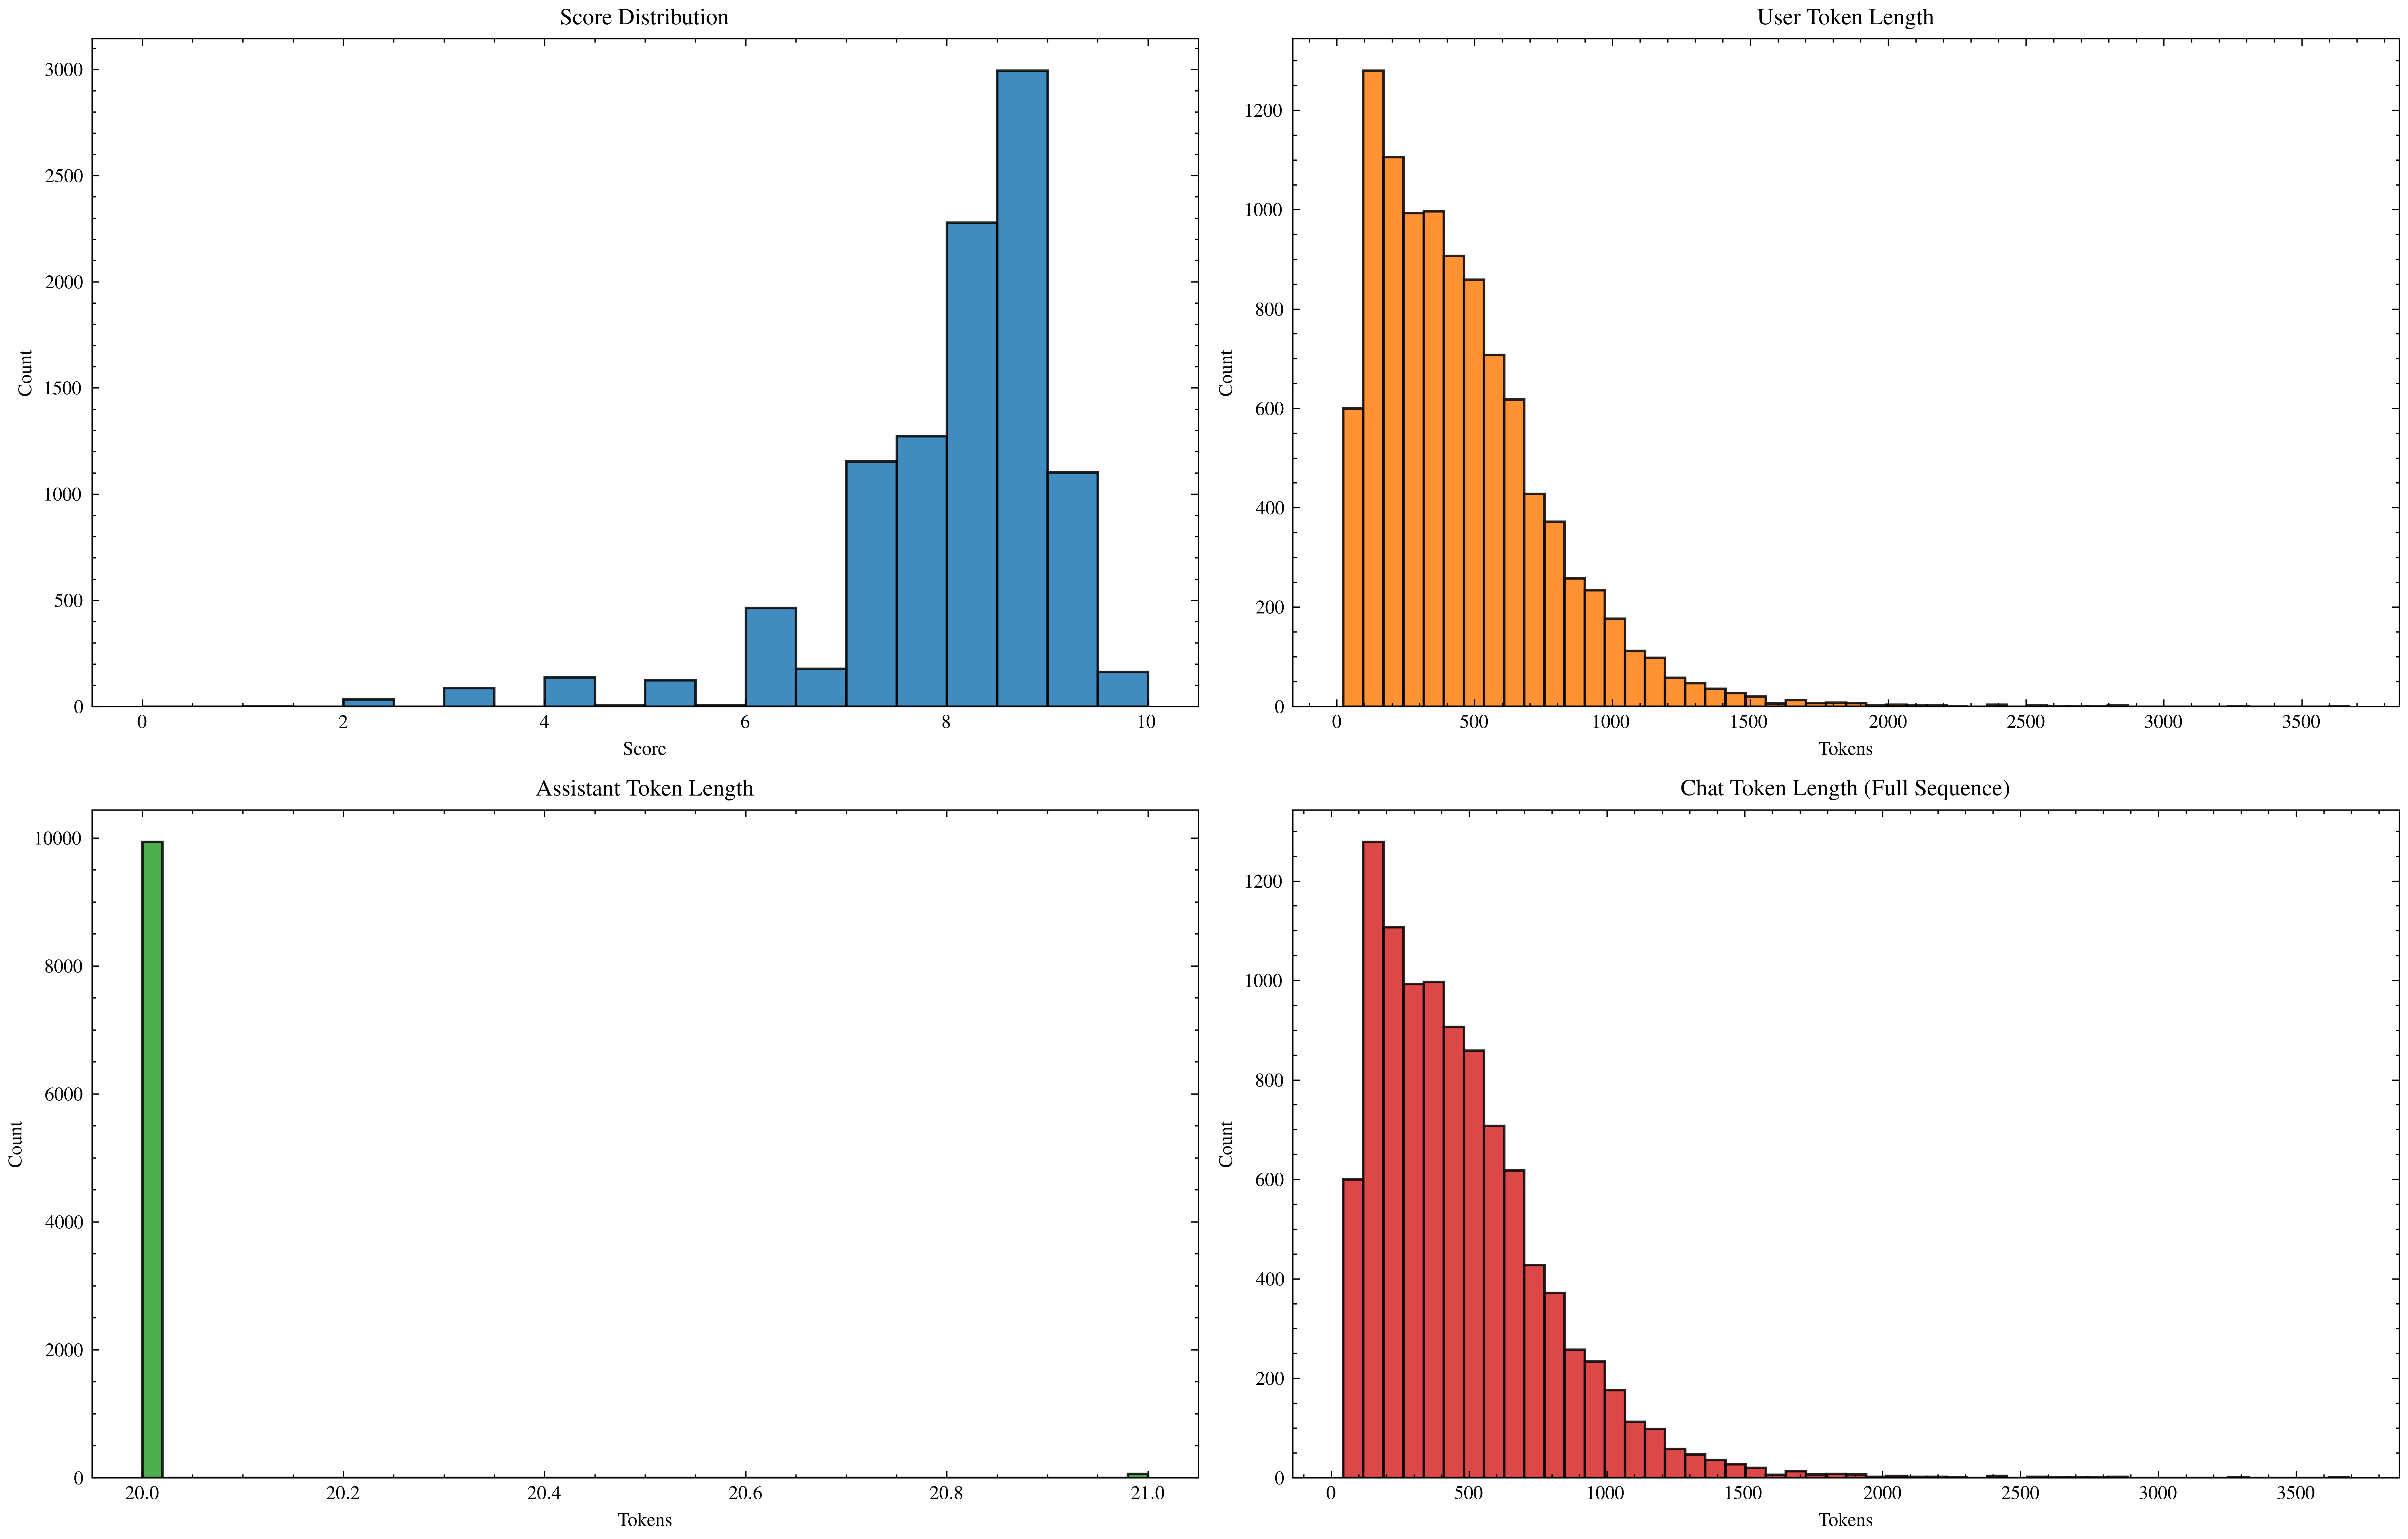

In [5]:
# ── Token-level distributions ─────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(14, 9))

axes[0, 0].hist(df["score"].dropna(), bins=np.arange(0, 10.5, 0.5),
                color="#1f77b4", edgecolor="black", alpha=0.85)
axes[0, 0].set_title("Score Distribution")
axes[0, 0].set_xlabel("Score")
axes[0, 0].set_ylabel("Count")

axes[0, 1].hist(df["user_tokens"], bins=50,
                color="#ff7f0e", edgecolor="black", alpha=0.85)
axes[0, 1].set_title("User Token Length")
axes[0, 1].set_xlabel("Tokens")
axes[0, 1].set_ylabel("Count")

axes[1, 0].hist(df["assistant_tokens"], bins=50,
                color="#2ca02c", edgecolor="black", alpha=0.85)
axes[1, 0].set_title("Assistant Token Length")
axes[1, 0].set_xlabel("Tokens")
axes[1, 0].set_ylabel("Count")

axes[1, 1].hist(df["chat_tokens"], bins=50,
                color="#d62728", edgecolor="black", alpha=0.85)
axes[1, 1].set_title("Chat Token Length (Full Sequence)")
axes[1, 1].set_xlabel("Tokens")
axes[1, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

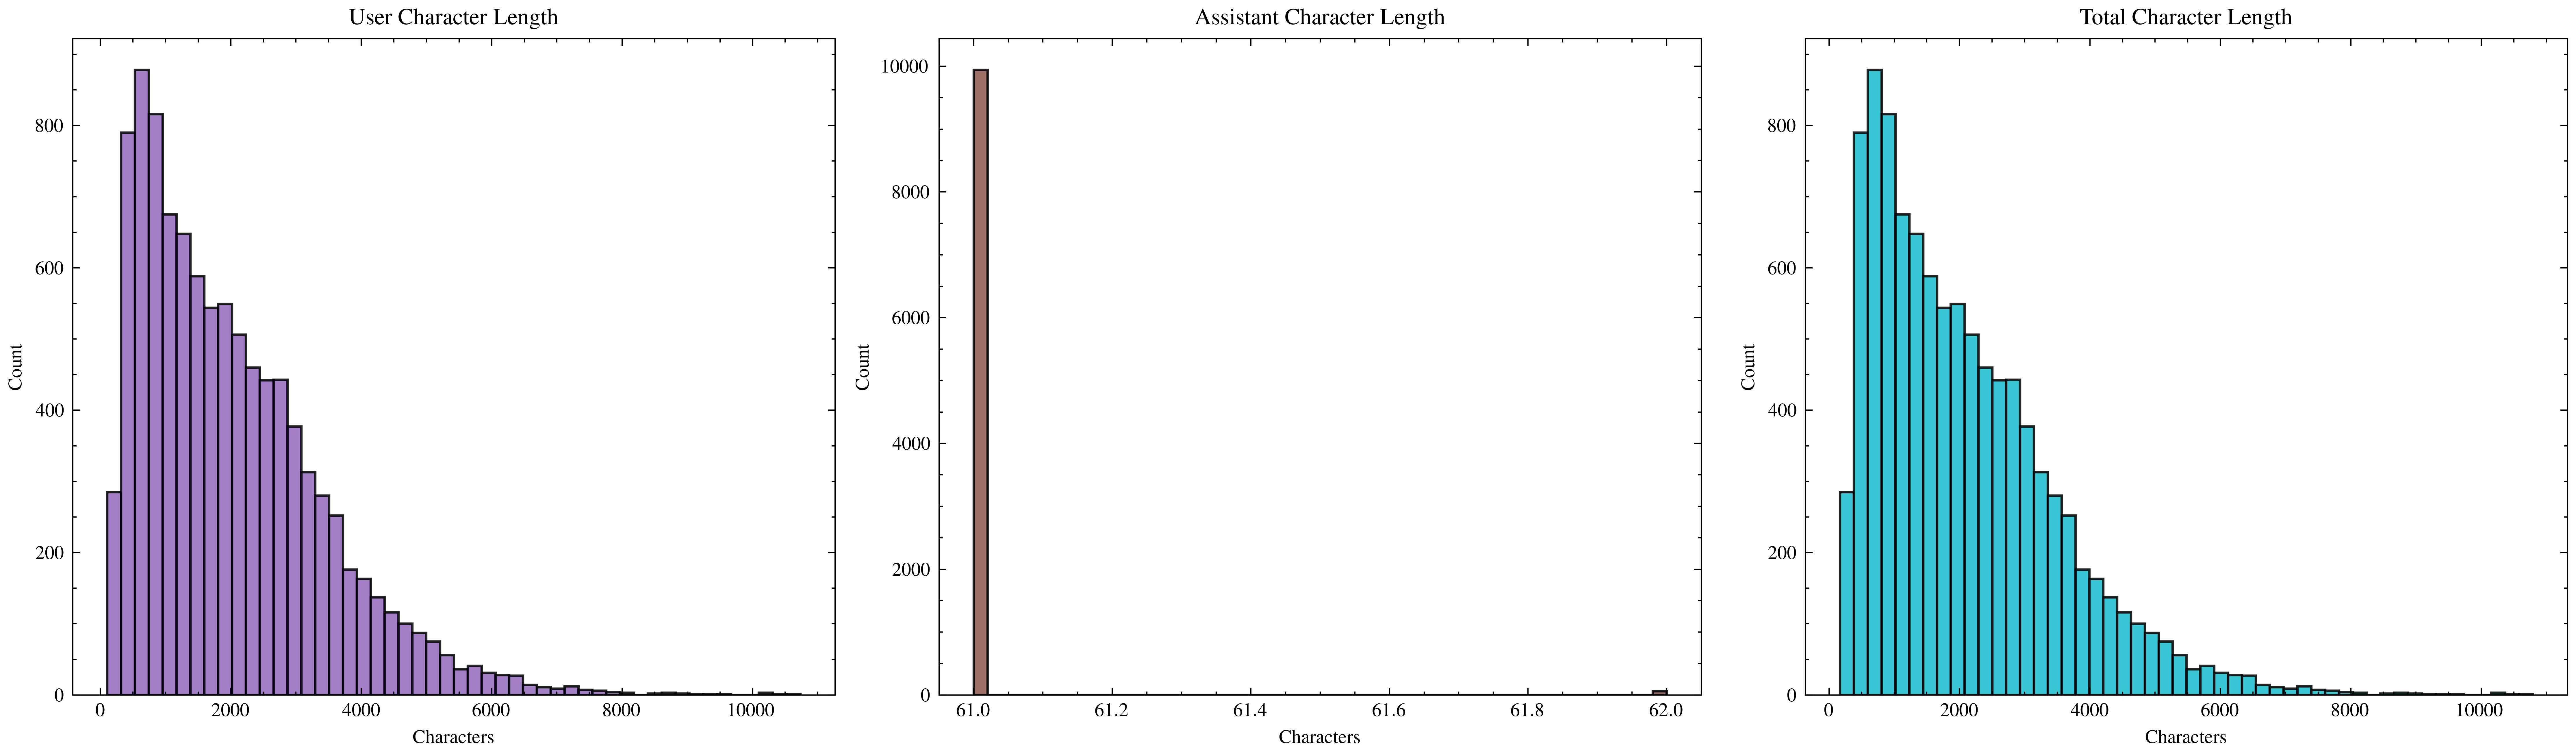

In [6]:
# ── Character-level distributions ────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

axes[0].hist(df["user_chars"], bins=50,
             color="#9467bd", edgecolor="black", alpha=0.85)
axes[0].set_title("User Character Length")
axes[0].set_xlabel("Characters")
axes[0].set_ylabel("Count")

axes[1].hist(df["assistant_chars"], bins=50,
             color="#8c564b", edgecolor="black", alpha=0.85)
axes[1].set_title("Assistant Character Length")
axes[1].set_xlabel("Characters")
axes[1].set_ylabel("Count")

axes[2].hist(df["total_chars"], bins=50,
             color="#17becf", edgecolor="black", alpha=0.85)
axes[2].set_title("Total Character Length")
axes[2].set_xlabel("Characters")
axes[2].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [7]:
# ── Longest sequences (by chat tokens) ───────────────────────────
display(df.nlargest(10, "chat_tokens")[["idx", "score", "user_tokens", "assistant_tokens", "chat_tokens"]])

,idx,score,user_tokens,assistant_tokens,chat_tokens
4535,4535,5.0,3671,20,3691
2136,2136,8.5,3249,20,3269
7942,7942,7.5,2831,20,2851
160,160,1.0,2796,20,2816
1358,1358,6.0,2767,20,2787
5334,5334,8.0,2677,20,2697
7048,7048,8.5,2648,20,2668
6987,6987,8.0,2569,20,2589
9648,9648,8.0,2557,20,2577
2149,2149,7.0,2393,20,2413
